In [3]:
import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.model as modellib
import os
import random
import xml.etree.ElementTree as ET
import xml
import numpy as np
import matplotlib.pyplot as plt
from mrcnn import visualize
from mrcnn.model import log
from os import listdir
from os.path import isfile, join

For this analysis we are going to be creating a mask rcnn to try and create a model that can identify faces. I chose a mask rcnn because it seems the like the fasest object detection algorithm for this case. I could've gone with YOLO but yolo does not do a good job at detecting small objects unlike a faster-rcnn which is what a mask-rcnn is composed of

In [4]:
#replace with your own images and annotation path here down below
images_path = r'C:\Users\brunolopez\Downloads\komi_analysis_pascal\JPEGImages'
annot_path = r'C:\Users\brunolopez\Downloads\komi_analysis_pascal\Annotations'

In [5]:
class komiDataSet(mrcnn.utils.Dataset):

    def load_dataset(self, is_train = True):
        self.add_class("dataset", 1, 'face') #only one class which is a face detector

        images_dir = images_path
        annotations_dir = annot_path

        files = [file for file in os.listdir(images_dir)]
        random.shuffle(files) #randomly shuffle the files

        #Get the length of the files and navigate 80 percent for training
        split = 0.7    
        split_index = int(np.floor(len(files) * split))
        
        if is_train:
            files = files[:split_index]
        else:
            files = files[split_index:]

        for filename in files:
            image_id = filename.split('.jpg')[0] #split at the jpg
            #contruct the image path 
            img_path =  images_dir + '/' + filename
            ann_path = annotations_dir + '/' + image_id + '.xml'

            self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)

    def extract_boxes(self, filename):
        #get all of the x and y max and mins of the annotations
	    tree = xml.etree.ElementTree.parse(filename)
	    root = tree.getroot()
	    boxes = list()
	    for box in root.findall('.//bndbox'):
		    xmin = int(float(box.find('xmin').text))
		    ymin = int(float(box.find('ymin').text))
		    xmax = int(float(box.find('xmax').text))
		    ymax = int(float(box.find('ymax').text))
		    coors = [xmin, ymin, xmax, ymax]
		    boxes.append(coors)

	    width = int(root.find('.//size/width').text)
	    height = int(root.find('.//size/height').text)
	    return boxes, width, height
    
    def load_mask(self, image_id):
	    info = self.image_info[image_id]
	    path = info['annotation']
	    boxes, w, h = self.extract_boxes(path)
	    masks = np.zeros([h, w, len(boxes)], dtype='uint8')
	    class_ids = list()
	    for i in range(len(boxes)):
		    box = boxes[i]
		    row_s, row_e = box[1], box[3]
		    col_s, col_e = box[0], box[2]
		    masks[row_s:row_e, col_s:col_e, i] = 1
		    class_ids.append(self.class_names.index('face'))
	    return masks, np.asarray(class_ids, dtype='int32')


#config file for the mask-rcnn. Two classes are face and background
class KomiConfig(mrcnn.config.Config):
    NAME = "komi_cfg"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 131

class InferenceConfig(KomiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

NameError: name 'mrcnn' is not defined

Prepare the training and testing dataset 

In [14]:
train_set = komiDataSet()
train_set.load_dataset(is_train=True)
train_set.prepare()

In [12]:
valid_dataset = komiDataSet()
valid_dataset.load_dataset(is_train=False)
valid_dataset.prepare()

In [7]:
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir= r'C:\Users\brunolopez\mldata\manga_scrape\komi_weights', 
                             config= KomiConfig())

Load the Coco Mask RCNN pretained model

In [8]:
coco_model = r'C:\Users\brunolopez\mldata\manga_scrape\mask_rcnn_coco.h5'

Load the pre trained model from the coco weights

In [9]:
model.load_weights(filepath=coco_model, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Validation set for the data

In [10]:
model.train(train_dataset=train_set, 
            val_dataset=valid_dataset, 
            learning_rate=KomiConfig().LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\brunolopez\mldata\manga_scrape\komi_weights\komi_cfg20230228T0241\mask_rcnn_komi_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:42:25 - loss: 2.5925 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.7804 - mrcnn_bbox_loss: 0.5855 - mrcnn_mask_loss: 0.9913

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:38:03 - loss: 2.8042 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.3157 - mrcnn_class_loss: 0.7846 - mrcnn_bbox_loss: 0.7424 - mrcnn_mask_loss: 0.9319

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:36:56 - loss: 2.5695 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2477 - mrcnn_class_loss: 0.6005 - mrcnn_bbox_loss: 0.7374 - mrcnn_mask_loss: 0.9608

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:34:11 - loss: 2.8015 - rpn_class_loss: 0.2404 - rpn_bbox_loss: 0.2898 - mrcnn_class_loss: 0.6149 - mrcnn_bbox_loss: 0.7291 - mrcnn_mask_loss: 0.9273

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:31:29 - loss: 2.5858 - rpn_class_loss: 0.1928 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.5094 - mrcnn_bbox_loss: 0.6920 - mrcnn_mask_loss: 0.9037

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:30:27 - loss: 2.5952 - rpn_class_loss: 0.1856 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.4749 - mrcnn_bbox_loss: 0.7137 - mrcnn_mask_loss: 0.8667

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:29:27 - loss: 2.6215 - rpn_class_loss: 0.2026 - rpn_bbox_loss: 0.3897 - mrcnn_class_loss: 0.4497 - mrcnn_bbox_loss: 0.7309 - mrcnn_mask_loss: 0.8485

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:28:54 - loss: 2.5348 - rpn_class_loss: 0.1787 - rpn_bbox_loss: 0.3801 - mrcnn_class_loss: 0.4017 - mrcnn_bbox_loss: 0.7422 - mrcnn_mask_loss: 0.8320

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:28:21 - loss: 2.5199 - rpn_class_loss: 0.1748 - rpn_bbox_loss: 0.3877 - mrcnn_class_loss: 0.4209 - mrcnn_bbox_loss: 0.7286 - mrcnn_mask_loss: 0.8079

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:27:12 - loss: 2.4941 - rpn_class_loss: 0.1666 - rpn_bbox_loss: 0.3840 - mrcnn_class_loss: 0.4365 - mrcnn_bbox_loss: 0.7182 - mrcnn_mask_loss: 0.7887

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:26:45 - loss: 2.5804 - rpn_class_loss: 0.1521 - rpn_bbox_loss: 0.4723 - mrcnn_class_loss: 0.3974 - mrcnn_bbox_loss: 0.7797 - mrcnn_mask_loss: 0.7790

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:26:02 - loss: 2.5769 - rpn_class_loss: 0.1716 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.4138 - mrcnn_bbox_loss: 0.7599 - mrcnn_mask_loss: 0.7591

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:24:58 - loss: 2.5434 - rpn_class_loss: 0.1606 - rpn_bbox_loss: 0.4645 - mrcnn_class_loss: 0.4109 - mrcnn_bbox_loss: 0.7629 - mrcnn_mask_loss: 0.7446

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:23:42 - loss: 2.5021 - rpn_class_loss: 0.1514 - rpn_bbox_loss: 0.4498 - mrcnn_class_loss: 0.4077 - mrcnn_bbox_loss: 0.7636 - mrcnn_mask_loss: 0.7297

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:23:49 - loss: 2.4722 - rpn_class_loss: 0.1435 - rpn_bbox_loss: 0.4364 - mrcnn_class_loss: 0.4267 - mrcnn_bbox_loss: 0.7528 - mrcnn_mask_loss: 0.7127

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:22:44 - loss: 2.4342 - rpn_class_loss: 0.1373 - rpn_bbox_loss: 0.4276 - mrcnn_class_loss: 0.4046 - mrcnn_bbox_loss: 0.7623 - mrcnn_mask_loss: 0.7024

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:22:09 - loss: 2.3762 - rpn_class_loss: 0.1306 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.3980 - mrcnn_bbox_loss: 0.7470 - mrcnn_mask_loss: 0.6909

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:21:55 - loss: 2.3733 - rpn_class_loss: 0.1302 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.4237 - mrcnn_bbox_loss: 0.7320 - mrcnn_mask_loss: 0.6776

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:21:26 - loss: 2.3274 - rpn_class_loss: 0.1248 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.4064 - mrcnn_bbox_loss: 0.7198 - mrcnn_mask_loss: 0.6686

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:20:39 - loss: 2.3024 - rpn_class_loss: 0.1210 - rpn_bbox_loss: 0.4066 - mrcnn_class_loss: 0.4028 - mrcnn_bbox_loss: 0.7135 - mrcnn_mask_loss: 0.6585

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:20:04 - loss: 2.2910 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.3865 - mrcnn_bbox_loss: 0.7102 - mrcnn_mask_loss: 0.6559

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:19:09 - loss: 2.2540 - rpn_class_loss: 0.1153 - rpn_bbox_loss: 0.4082 - mrcnn_class_loss: 0.3840 - mrcnn_bbox_loss: 0.7031 - mrcnn_mask_loss: 0.6434

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:18:18 - loss: 2.2368 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.3838 - mrcnn_bbox_loss: 0.6991 - mrcnn_mask_loss: 0.6365

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:17:21 - loss: 2.2052 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.3979 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 0.6892 - mrcnn_mask_loss: 0.6280

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:16:53 - loss: 2.1945 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 0.3998 - mrcnn_class_loss: 0.3788 - mrcnn_bbox_loss: 0.6902 - mrcnn_mask_loss: 0.6202

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:16:00 - loss: 2.1770 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 0.3957 - mrcnn_class_loss: 0.3778 - mrcnn_bbox_loss: 0.6854 - mrcnn_mask_loss: 0.6139

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:15:37 - loss: 2.1423 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.3893 - mrcnn_class_loss: 0.3689 - mrcnn_bbox_loss: 0.6737 - mrcnn_mask_loss: 0.6078

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:14:55 - loss: 2.1185 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.3836 - mrcnn_class_loss: 0.3610 - mrcnn_bbox_loss: 0.6700 - mrcnn_mask_loss: 0.6036

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:14:06 - loss: 2.0951 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 0.3820 - mrcnn_class_loss: 0.3575 - mrcnn_bbox_loss: 0.6608 - mrcnn_mask_loss: 0.5964

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:12:56 - loss: 2.0803 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 0.3785 - mrcnn_class_loss: 0.3548 - mrcnn_bbox_loss: 0.6588 - mrcnn_mask_loss: 0.5913

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:11:49 - loss: 2.0643 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 0.3781 - mrcnn_class_loss: 0.3473 - mrcnn_bbox_loss: 0.6570 - mrcnn_mask_loss: 0.5871

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:10:36 - loss: 2.0373 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 0.3759 - mrcnn_class_loss: 0.3402 - mrcnn_bbox_loss: 0.6478 - mrcnn_mask_loss: 0.5803

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:09:25 - loss: 2.0241 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.3733 - mrcnn_class_loss: 0.3422 - mrcnn_bbox_loss: 0.6429 - mrcnn_mask_loss: 0.5744

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:08:16 - loss: 2.0140 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 0.3716 - mrcnn_class_loss: 0.3469 - mrcnn_bbox_loss: 0.6355 - mrcnn_mask_loss: 0.5691

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:07:09 - loss: 1.9973 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 0.3711 - mrcnn_class_loss: 0.3422 - mrcnn_bbox_loss: 0.6277 - mrcnn_mask_loss: 0.5657

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:06:05 - loss: 1.9830 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 0.3707 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.6244 - mrcnn_mask_loss: 0.5613

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:05:04 - loss: 1.9652 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 0.3655 - mrcnn_class_loss: 0.3350 - mrcnn_bbox_loss: 0.6195 - mrcnn_mask_loss: 0.5576

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:04:09 - loss: 1.9552 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 0.3657 - mrcnn_class_loss: 0.3307 - mrcnn_bbox_loss: 0.6162 - mrcnn_mask_loss: 0.5557

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:03:12 - loss: 1.9511 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 0.3683 - mrcnn_class_loss: 0.3296 - mrcnn_bbox_loss: 0.6134 - mrcnn_mask_loss: 0.5504

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:02:19 - loss: 1.9348 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 0.3657 - mrcnn_class_loss: 0.3266 - mrcnn_bbox_loss: 0.6095 - mrcnn_mask_loss: 0.5457

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:01:26 - loss: 1.9330 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 0.3675 - mrcnn_class_loss: 0.3324 - mrcnn_bbox_loss: 0.6057 - mrcnn_mask_loss: 0.5411

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:00:29 - loss: 1.9272 - rpn_class_loss: 0.0850 - rpn_bbox_loss: 0.3692 - mrcnn_class_loss: 0.3323 - mrcnn_bbox_loss: 0.6038 - mrcnn_mask_loss: 0.5370

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 59:34 - loss: 1.9996 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 0.4364 - mrcnn_class_loss: 0.3302 - mrcnn_bbox_loss: 0.6092 - mrcnn_mask_loss: 0.5346  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 58:40 - loss: 1.9875 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.4338 - mrcnn_class_loss: 0.3262 - mrcnn_bbox_loss: 0.6072 - mrcnn_mask_loss: 0.5326

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 57:50 - loss: 1.9656 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 0.4263 - mrcnn_class_loss: 0.3226 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.5278

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 57:01 - loss: 1.9558 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.3212 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.5251

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 56:12 - loss: 1.9549 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 0.4211 - mrcnn_class_loss: 0.3257 - mrcnn_bbox_loss: 0.6007 - mrcnn_mask_loss: 0.5223

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 55:22 - loss: 1.9353 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.3217 - mrcnn_bbox_loss: 0.5963 - mrcnn_mask_loss: 0.5187

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 54:32 - loss: 1.9226 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 0.4133 - mrcnn_class_loss: 0.3159 - mrcnn_bbox_loss: 0.5928 - mrcnn_mask_loss: 0.5178

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 53:45 - loss: 1.9143 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.3179 - mrcnn_bbox_loss: 0.5888 - mrcnn_mask_loss: 0.5148

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 52:56 - loss: 1.9010 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.3156 - mrcnn_bbox_loss: 0.5863 - mrcnn_mask_loss: 0.5120

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 52:08 - loss: 1.8804 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.3112 - mrcnn_bbox_loss: 0.5797 - mrcnn_mask_loss: 0.5081

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 51:22 - loss: 1.8742 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 0.3982 - mrcnn_class_loss: 0.3131 - mrcnn_bbox_loss: 0.5770 - mrcnn_mask_loss: 0.5051

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 50:37 - loss: 1.8658 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 0.3932 - mrcnn_class_loss: 0.3171 - mrcnn_bbox_loss: 0.5729 - mrcnn_mask_loss: 0.5016

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 49:48 - loss: 1.8587 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 0.3899 - mrcnn_class_loss: 0.3157 - mrcnn_bbox_loss: 0.5712 - mrcnn_mask_loss: 0.5017

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 49:01 - loss: 1.8500 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.3893 - mrcnn_class_loss: 0.3148 - mrcnn_bbox_loss: 0.5671 - mrcnn_mask_loss: 0.4988

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 48:16 - loss: 1.8459 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 0.3905 - mrcnn_class_loss: 0.3153 - mrcnn_bbox_loss: 0.5647 - mrcnn_mask_loss: 0.4960

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 47:28 - loss: 1.8398 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 0.3881 - mrcnn_class_loss: 0.3172 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.4941

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 46:41 - loss: 1.8266 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 0.3851 - mrcnn_class_loss: 0.3161 - mrcnn_bbox_loss: 0.5568 - mrcnn_mask_loss: 0.4906

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 45:55 - loss: 1.8199 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.3837 - mrcnn_class_loss: 0.3181 - mrcnn_bbox_loss: 0.5530 - mrcnn_mask_loss: 0.4880

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 45:11 - loss: 1.8070 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.3811 - mrcnn_class_loss: 0.3135 - mrcnn_bbox_loss: 0.5500 - mrcnn_mask_loss: 0.4857

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 44:27 - loss: 1.7955 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.3789 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.5453 - mrcnn_mask_loss: 0.4832

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 43:44 - loss: 1.7927 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 0.3776 - mrcnn_class_loss: 0.3122 - mrcnn_bbox_loss: 0.5428 - mrcnn_mask_loss: 0.4817

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 43:01 - loss: 1.7902 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 0.3774 - mrcnn_class_loss: 0.3139 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.4803

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 42:18 - loss: 1.7812 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.3742 - mrcnn_class_loss: 0.3143 - mrcnn_bbox_loss: 0.5370 - mrcnn_mask_loss: 0.4784

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 41:34 - loss: 1.7737 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.3721 - mrcnn_class_loss: 0.3142 - mrcnn_bbox_loss: 0.5338 - mrcnn_mask_loss: 0.4770

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 40:52 - loss: 1.7696 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.3702 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.5368 - mrcnn_mask_loss: 0.4742

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 40:10 - loss: 1.7547 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.3680 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.5312 - mrcnn_mask_loss: 0.4719

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 39:26 - loss: 1.7448 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.3653 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.5281 - mrcnn_mask_loss: 0.4697

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 38:44 - loss: 1.7445 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.3637 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.5269 - mrcnn_mask_loss: 0.4690

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 38:01 - loss: 1.7410 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.3605 - mrcnn_class_loss: 0.3129 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.4680

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 37:20 - loss: 1.7474 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.3684 - mrcnn_class_loss: 0.3116 - mrcnn_bbox_loss: 0.5246 - mrcnn_mask_loss: 0.4678

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 36:38 - loss: 1.7361 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 0.3651 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.5212 - mrcnn_mask_loss: 0.4655

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 35:57 - loss: 1.7262 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.3635 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.5188 - mrcnn_mask_loss: 0.4639

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 35:17 - loss: 1.7216 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 0.3611 - mrcnn_class_loss: 0.3067 - mrcnn_bbox_loss: 0.5172 - mrcnn_mask_loss: 0.4631

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 34:37 - loss: 1.7134 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 0.3587 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.5142 - mrcnn_mask_loss: 0.4619

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 33:56 - loss: 1.7138 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 0.3579 - mrcnn_class_loss: 0.3084 - mrcnn_bbox_loss: 0.5135 - mrcnn_mask_loss: 0.4609

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 33:15 - loss: 1.7108 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 0.3560 - mrcnn_class_loss: 0.3105 - mrcnn_bbox_loss: 0.5120 - mrcnn_mask_loss: 0.4596

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 32:35 - loss: 1.7081 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.3552 - mrcnn_class_loss: 0.3111 - mrcnn_bbox_loss: 0.5103 - mrcnn_mask_loss: 0.4586

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 31:55 - loss: 1.7011 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.3540 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.5082 - mrcnn_mask_loss: 0.4579

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 31:14 - loss: 1.6967 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.4564

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 30:34 - loss: 1.6888 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.3514 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.5038 - mrcnn_mask_loss: 0.4552

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 29:53 - loss: 1.6821 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.3506 - mrcnn_class_loss: 0.3037 - mrcnn_bbox_loss: 0.5024 - mrcnn_mask_loss: 0.4536

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 29:13 - loss: 1.6776 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.3499 - mrcnn_class_loss: 0.3035 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.4519

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 28:34 - loss: 1.6726 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.3499 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.4988 - mrcnn_mask_loss: 0.4505

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 27:55 - loss: 1.6650 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.3003 - mrcnn_bbox_loss: 0.4965 - mrcnn_mask_loss: 0.4500

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 27:16 - loss: 1.6582 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.3451 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.4951 - mrcnn_mask_loss: 0.4486

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 26:38 - loss: 1.6518 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 0.3433 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.4937 - mrcnn_mask_loss: 0.4474

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 25:59 - loss: 1.6474 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 0.3421 - mrcnn_class_loss: 0.2979 - mrcnn_bbox_loss: 0.4917 - mrcnn_mask_loss: 0.4464

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 25:20 - loss: 1.6407 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.3405 - mrcnn_class_loss: 0.2969 - mrcnn_bbox_loss: 0.4890 - mrcnn_mask_loss: 0.4451

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 24:42 - loss: 1.6366 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.3399 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.4873 - mrcnn_mask_loss: 0.4443

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 24:02 - loss: 1.6381 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 0.3390 - mrcnn_class_loss: 0.2933 - mrcnn_bbox_loss: 0.4903 - mrcnn_mask_loss: 0.4472

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 23:24 - loss: 1.6356 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.3385 - mrcnn_class_loss: 0.2921 - mrcnn_bbox_loss: 0.4910 - mrcnn_mask_loss: 0.4460

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 22:45 - loss: 1.6262 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.3353 - mrcnn_class_loss: 0.2892 - mrcnn_bbox_loss: 0.4881 - mrcnn_mask_loss: 0.4457

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 22:06 - loss: 1.6201 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.2874 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.4442

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 21:28 - loss: 1.6168 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.3321 - mrcnn_class_loss: 0.2871 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.4433

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 20:50 - loss: 1.6156 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.3319 - mrcnn_class_loss: 0.2882 - mrcnn_bbox_loss: 0.4861 - mrcnn_mask_loss: 0.4427

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 20:12 - loss: 1.6063 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.3294 - mrcnn_class_loss: 0.2861 - mrcnn_bbox_loss: 0.4836 - mrcnn_mask_loss: 0.4411

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 19:34 - loss: 1.5992 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.3274 - mrcnn_class_loss: 0.2856 - mrcnn_bbox_loss: 0.4807 - mrcnn_mask_loss: 0.4399

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 18:56 - loss: 1.5943 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 0.3262 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4394

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 18:19 - loss: 1.5926 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.3278 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.4379

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 17:41 - loss: 1.5908 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.3273 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.4366

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 17:04 - loss: 1.5848 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.3264 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.4733 - mrcnn_mask_loss: 0.4353

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 16:26 - loss: 1.5792 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.4708 - mrcnn_mask_loss: 0.4338

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 15:49 - loss: 1.5778 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.3265 - mrcnn_class_loss: 0.2829 - mrcnn_bbox_loss: 0.4688 - mrcnn_mask_loss: 0.4332

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 15:12 - loss: 1.5707 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.3248 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 0.4659 - mrcnn_mask_loss: 0.4318

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 14:35 - loss: 1.5676 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.3237 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.4322

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 13:58 - loss: 1.5624 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.3219 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.4311

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 13:20 - loss: 1.5557 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.3200 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.4621 - mrcnn_mask_loss: 0.4298

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 12:43 - loss: 1.5529 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.3212 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.4290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 12:06 - loss: 1.5504 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.3209 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.4579 - mrcnn_mask_loss: 0.4279

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 11:29 - loss: 1.5430 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.3195 - mrcnn_class_loss: 0.2770 - mrcnn_bbox_loss: 0.4551 - mrcnn_mask_loss: 0.4271

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 10:53 - loss: 1.5381 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 0.3185 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.4537 - mrcnn_mask_loss: 0.4264

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 10:16 - loss: 1.5307 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.3163 - mrcnn_class_loss: 0.2734 - mrcnn_bbox_loss: 0.4525 - mrcnn_mask_loss: 0.4249

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 9:39 - loss: 1.5291 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.4521 - mrcnn_mask_loss: 0.4241 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 9:03 - loss: 1.5250 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.3149 - mrcnn_class_loss: 0.2727 - mrcnn_bbox_loss: 0.4508 - mrcnn_mask_loss: 0.4236

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 8:26 - loss: 1.5236 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.3153 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.4231

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 7:49 - loss: 1.5186 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.3140 - mrcnn_class_loss: 0.2712 - mrcnn_bbox_loss: 0.4493 - mrcnn_mask_loss: 0.4218

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 7:13 - loss: 1.5154 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.3134 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.4476 - mrcnn_mask_loss: 0.4209

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:37 - loss: 1.5105 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.3121 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.4472 - mrcnn_mask_loss: 0.4198

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:01 - loss: 1.5034 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.3098 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.4455 - mrcnn_mask_loss: 0.4183

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:24 - loss: 1.5027 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.3091 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.4176

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:48 - loss: 1.4983 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.3082 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.4433 - mrcnn_mask_loss: 0.4171

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:12 - loss: 1.4923 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.3070 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.4160

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:36 - loss: 1.4867 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.3057 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.4393 - mrcnn_mask_loss: 0.4149

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:00 - loss: 1.4863 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.3061 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.4145

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:24 - loss: 1.4849 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.4138

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:48 - loss: 1.4856 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.4392 - mrcnn_mask_loss: 0.4134

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:12 - loss: 1.4823 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.3046 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.4385 - mrcnn_mask_loss: 0.4123

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 35s - loss: 1.4781 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.4112 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 5344s 41s/step - loss: 1.4750 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.4365 - mrcnn_mask_loss: 0.4103 - val_loss: 1.1770 - val_rpn_class_loss: 0.0433 - val_rpn_bbox_loss: 0.2497 - val_mrcnn_class_loss: 0.2427 - val_mrcnn_bbox_loss: 0.3075 - val_mrcnn_mask_loss: 0.3338
Epoch 2/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:24:48 - loss: 1.2061 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.3496 - mrcnn_mask_loss: 0.3417

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:24:28 - loss: 1.3298 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.3563

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:18:38 - loss: 1.1917 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2298 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.3424

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:16:54 - loss: 1.2528 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.3310

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:15:36 - loss: 1.2740 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2307 - mrcnn_class_loss: 0.3037 - mrcnn_bbox_loss: 0.3638 - mrcnn_mask_loss: 0.3386

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:14:25 - loss: 1.2778 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.3633 - mrcnn_mask_loss: 0.3447

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:12:58 - loss: 1.3212 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.2343 - mrcnn_class_loss: 0.3180 - mrcnn_bbox_loss: 0.3731 - mrcnn_mask_loss: 0.3502

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:11:43 - loss: 1.2659 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.3515 - mrcnn_mask_loss: 0.3406

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:10:46 - loss: 1.2473 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.3382

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:10:04 - loss: 1.2405 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2390 - mrcnn_class_loss: 0.2901 - mrcnn_bbox_loss: 0.3289 - mrcnn_mask_loss: 0.3397

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:09:13 - loss: 1.2116 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.3196 - mrcnn_mask_loss: 0.3366

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:08:19 - loss: 1.2187 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.3380

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:07:24 - loss: 1.1982 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.2294 - mrcnn_class_loss: 0.2722 - mrcnn_bbox_loss: 0.3200 - mrcnn_mask_loss: 0.3365

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:06:51 - loss: 1.1837 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.3134 - mrcnn_mask_loss: 0.3368

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:06:00 - loss: 1.1433 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.3114 - mrcnn_mask_loss: 0.3291

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:05:19 - loss: 1.1788 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.2750 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.3300

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:04:45 - loss: 1.1711 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.3305

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:04:13 - loss: 1.1547 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.3288

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:03:31 - loss: 1.1365 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.3276

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:02:48 - loss: 1.1312 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.2995 - mrcnn_mask_loss: 0.3282

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:02:04 - loss: 1.1157 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.2058 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.3253

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:01:31 - loss: 1.0963 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.2037 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.2920 - mrcnn_mask_loss: 0.3242

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:01:02 - loss: 1.1157 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 0.3269

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:00:20 - loss: 1.1106 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.3271

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 59:49 - loss: 1.1194 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.2030 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.3275  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 59:11 - loss: 1.1329 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.3111 - mrcnn_mask_loss: 0.3270

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 58:38 - loss: 1.1294 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.3254

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 58:01 - loss: 1.1202 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.3255

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 57:21 - loss: 1.1153 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.2034 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.3283

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 56:42 - loss: 1.1118 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.2021 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 0.3281

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 56:04 - loss: 1.1158 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.3275

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 55:32 - loss: 1.1083 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.3265

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 55:00 - loss: 1.1032 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.2071 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.3056 - mrcnn_mask_loss: 0.3270

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 54:21 - loss: 1.1087 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.3272

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 53:43 - loss: 1.0944 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2087 - mrcnn_class_loss: 0.2264 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.3252

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 53:10 - loss: 1.1117 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.3263

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 52:32 - loss: 1.1121 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.2107 - mrcnn_class_loss: 0.2359 - mrcnn_bbox_loss: 0.3030 - mrcnn_mask_loss: 0.3267

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 51:57 - loss: 1.1131 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.3260

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 51:23 - loss: 1.1023 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.2055 - mrcnn_class_loss: 0.2332 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.3235

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 50:46 - loss: 1.1002 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.2332 - mrcnn_bbox_loss: 0.3038 - mrcnn_mask_loss: 0.3230

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 50:11 - loss: 1.0900 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.2037 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.3209

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 49:35 - loss: 1.0888 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.3202

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 49:00 - loss: 1.0764 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1989 - mrcnn_class_loss: 0.2240 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.3197

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 48:28 - loss: 1.0744 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1984 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.3194

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 47:55 - loss: 1.0722 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1982 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.3186

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 47:23 - loss: 1.0815 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1998 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.3032 - mrcnn_mask_loss: 0.3197

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 46:52 - loss: 1.0815 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1992 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.3030 - mrcnn_mask_loss: 0.3207

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 46:17 - loss: 1.0807 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1977 - mrcnn_class_loss: 0.2247 - mrcnn_bbox_loss: 0.3038 - mrcnn_mask_loss: 0.3216

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 45:42 - loss: 1.0801 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1977 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.3046 - mrcnn_mask_loss: 0.3214

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 45:08 - loss: 1.0797 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_loss: 0.3218

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 44:32 - loss: 1.0798 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.3065 - mrcnn_mask_loss: 0.3216

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 43:58 - loss: 1.0760 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1975 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.3203

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 43:23 - loss: 1.0809 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.3052 - mrcnn_mask_loss: 0.3196

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 42:48 - loss: 1.0778 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.1991 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.3050 - mrcnn_mask_loss: 0.3191

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 42:13 - loss: 1.0848 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.2002 - mrcnn_class_loss: 0.2239 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 0.3192

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 41:39 - loss: 1.0792 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.3048 - mrcnn_mask_loss: 0.3184

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 41:04 - loss: 1.0742 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.1978 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.3172

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 40:29 - loss: 1.0751 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.1989 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.3163

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 39:54 - loss: 1.0720 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1977 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.3158

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 39:22 - loss: 1.0722 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1949 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.3224

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 38:47 - loss: 1.0729 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1973 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.3221

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 38:14 - loss: 1.0764 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.3219

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 37:42 - loss: 1.0804 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.3221

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 37:08 - loss: 1.0765 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1995 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.3026 - mrcnn_mask_loss: 0.3212

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 36:35 - loss: 1.0779 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.3210

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 36:01 - loss: 1.0788 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1998 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.3212

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 35:29 - loss: 1.0782 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.3022 - mrcnn_mask_loss: 0.3212

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 34:55 - loss: 1.0707 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.3197

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 34:21 - loss: 1.0640 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.2173 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.3184

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 33:46 - loss: 1.0650 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.3173

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 33:12 - loss: 1.0630 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.3162

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 32:39 - loss: 1.0764 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.3169

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 32:06 - loss: 1.0815 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.3167

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 31:34 - loss: 1.0815 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.3167

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 31:00 - loss: 1.0804 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.2055 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.3012 - mrcnn_mask_loss: 0.3162

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 30:27 - loss: 1.0859 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2071 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.3166

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 29:53 - loss: 1.0854 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2067 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.3163

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 29:19 - loss: 1.0814 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.3158

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 28:47 - loss: 1.0783 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.2216 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.3151

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 28:14 - loss: 1.0751 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.3145

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 27:40 - loss: 1.0733 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.3145

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 27:07 - loss: 1.0746 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.3144

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 26:33 - loss: 1.0796 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.3147

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 26:00 - loss: 1.0737 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2027 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.3136

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 25:27 - loss: 1.0722 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2016 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.3138

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 24:54 - loss: 1.0719 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.2027 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.3140

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 24:21 - loss: 1.0684 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2024 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 0.3136

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 23:47 - loss: 1.0682 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.2040 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.3128

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 23:14 - loss: 1.0679 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.3124

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 22:41 - loss: 1.0669 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 0.3118

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 22:08 - loss: 1.0635 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.2044 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.3110

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 21:35 - loss: 1.0635 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.3109

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 21:02 - loss: 1.0621 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.3138

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 20:28 - loss: 1.0639 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.2932 - mrcnn_mask_loss: 0.3140

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 19:55 - loss: 1.0584 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.3131

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 19:22 - loss: 1.0595 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.2018 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.3134

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 18:49 - loss: 1.0635 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.2913 - mrcnn_mask_loss: 0.3138

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 18:15 - loss: 1.0613 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.2018 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.2901 - mrcnn_mask_loss: 0.3133

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 17:42 - loss: 1.0598 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.2011 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.3134

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 17:08 - loss: 1.0576 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.2006 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.2885 - mrcnn_mask_loss: 0.3138

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 16:36 - loss: 1.0550 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1997 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.3133

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 16:03 - loss: 1.0518 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.2864 - mrcnn_mask_loss: 0.3133

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 15:29 - loss: 1.0562 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1990 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.2875 - mrcnn_mask_loss: 0.3138

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 14:56 - loss: 1.0508 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.3131

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 14:23 - loss: 1.0509 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.2173 - mrcnn_bbox_loss: 0.2863 - mrcnn_mask_loss: 0.3128

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 13:49 - loss: 1.0528 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.3128

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 13:16 - loss: 1.0511 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.1984 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.3132

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 12:43 - loss: 1.0491 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1989 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.2845 - mrcnn_mask_loss: 0.3123

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 12:10 - loss: 1.0446 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.2836 - mrcnn_mask_loss: 0.3114

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 11:36 - loss: 1.0431 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2828 - mrcnn_mask_loss: 0.3111

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 11:03 - loss: 1.0395 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 0.3112

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 10:30 - loss: 1.0438 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.3116

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 9:57 - loss: 1.0442 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.1978 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.2821 - mrcnn_mask_loss: 0.3118 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 9:24 - loss: 1.0430 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.1974 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.2816 - mrcnn_mask_loss: 0.3117

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 8:51 - loss: 1.0403 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1965 - mrcnn_class_loss: 0.2151 - mrcnn_bbox_loss: 0.2807 - mrcnn_mask_loss: 0.3112

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 8:17 - loss: 1.0398 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.2801 - mrcnn_mask_loss: 0.3113

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 7:44 - loss: 1.0401 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.3112

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 7:11 - loss: 1.0363 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1958 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.2785 - mrcnn_mask_loss: 0.3106

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 6:38 - loss: 1.0367 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.3105

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:05 - loss: 1.0359 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1955 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.3107

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 5:32 - loss: 1.0367 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.2773 - mrcnn_mask_loss: 0.3104

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 4:58 - loss: 1.0363 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.2775 - mrcnn_mask_loss: 0.3108

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:25 - loss: 1.0330 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2768 - mrcnn_mask_loss: 0.3103

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 3:52 - loss: 1.0332 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.3103

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:19 - loss: 1.0365 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1960 - mrcnn_class_loss: 0.2171 - mrcnn_bbox_loss: 0.2764 - mrcnn_mask_loss: 0.3105

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 2:46 - loss: 1.0328 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.2754 - mrcnn_mask_loss: 0.3105

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:12 - loss: 1.0326 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1952 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.3105

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:39 - loss: 1.0296 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.2739 - mrcnn_mask_loss: 0.3100

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:06 - loss: 1.0302 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.3101

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 33s - loss: 1.0291 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 0.3099 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 4938s 38s/step - loss: 1.0279 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.1939 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.3102 - val_loss: 0.9854 - val_rpn_class_loss: 0.0342 - val_rpn_bbox_loss: 0.2027 - val_mrcnn_class_loss: 0.1811 - val_mrcnn_bbox_loss: 0.2721 - val_mrcnn_mask_loss: 0.2953
Epoch 3/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:09:39 - loss: 0.8721 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.2448 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.3093

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:09:55 - loss: 0.8549 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.1817 - mrcnn_class_loss: 0.1810 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.2853

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:10:16 - loss: 0.8587 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.1999 - mrcnn_mask_loss: 0.2741

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:09:38 - loss: 1.0237 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.2099 - mrcnn_bbox_loss: 0.2512 - mrcnn_mask_loss: 0.3057

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:09:35 - loss: 1.0629 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2406 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.2593 - mrcnn_mask_loss: 0.3043

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:09:13 - loss: 0.9932 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.1919 - mrcnn_bbox_loss: 0.2581 - mrcnn_mask_loss: 0.2916

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:08:44 - loss: 1.0013 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.1806 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.3060

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:07:54 - loss: 1.0163 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.2661 - mrcnn_mask_loss: 0.3056

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:07:02 - loss: 1.0201 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.2433 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.2740 - mrcnn_mask_loss: 0.3025

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:06:25 - loss: 1.0145 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.3063

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:06:04 - loss: 0.9761 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.1653 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.2981

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:05:20 - loss: 0.9240 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.1521 - mrcnn_bbox_loss: 0.2508 - mrcnn_mask_loss: 0.2872

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:04:43 - loss: 0.9228 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.2011 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.2517 - mrcnn_mask_loss: 0.2879

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:04:06 - loss: 0.9159 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.2897

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:03:41 - loss: 0.8951 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1915 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 0.2864

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:03:18 - loss: 0.8950 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.1490 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.2891

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:02:35 - loss: 0.8738 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.1830 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.2854

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:02:01 - loss: 0.8879 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.1861 - mrcnn_class_loss: 0.1521 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.2871

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:01:22 - loss: 0.8753 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.2338 - mrcnn_mask_loss: 0.2870

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:00:58 - loss: 0.8707 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.1471 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.2877

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:00:32 - loss: 0.8761 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.1804 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2891

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 59:55 - loss: 0.8810 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.3028  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 59:20 - loss: 0.8775 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.1470 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.3013

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 58:54 - loss: 0.8818 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1766 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.3018

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 58:19 - loss: 0.8667 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1725 - mrcnn_class_loss: 0.1444 - mrcnn_bbox_loss: 0.2306 - mrcnn_mask_loss: 0.2984

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 57:40 - loss: 0.8565 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1677 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.2290 - mrcnn_mask_loss: 0.2947

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 57:04 - loss: 0.8433 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1625 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.2271 - mrcnn_mask_loss: 0.2918

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 56:36 - loss: 0.8364 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1623 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.2906

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 56:02 - loss: 0.8435 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1665 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.2909

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 55:33 - loss: 0.8331 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1644 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.2888

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 55:04 - loss: 0.8306 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.2888

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 54:27 - loss: 0.8338 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1688 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.2892

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 53:53 - loss: 0.8308 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1678 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2880

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 53:16 - loss: 0.8325 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1673 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.2884

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 52:45 - loss: 0.8364 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.2881

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 52:09 - loss: 0.8374 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1670 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.2872

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 51:34 - loss: 0.8358 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.2180 - mrcnn_mask_loss: 0.2866

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 51:01 - loss: 0.8534 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1688 - mrcnn_class_loss: 0.1539 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.2885

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 50:27 - loss: 0.8602 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.2894

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 49:57 - loss: 0.8541 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.2879

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 49:24 - loss: 0.8537 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1704 - mrcnn_class_loss: 0.1558 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.2863

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 48:50 - loss: 0.8511 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.1544 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.2864

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 48:19 - loss: 0.8515 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.2873

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 47:45 - loss: 0.8557 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.1571 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.2880

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 47:10 - loss: 0.8541 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.1572 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.2869

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 46:36 - loss: 0.8486 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.2841

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 46:02 - loss: 0.8432 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1680 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.2824

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 45:28 - loss: 0.8508 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.1565 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.2831

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 44:55 - loss: 0.8504 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.1690 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.2840

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 44:24 - loss: 0.8489 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.1552 - mrcnn_bbox_loss: 0.2180 - mrcnn_mask_loss: 0.2843

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 43:50 - loss: 0.8487 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.1554 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.2840

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 43:16 - loss: 0.8435 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1674 - mrcnn_class_loss: 0.1529 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.2833

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 42:43 - loss: 0.8491 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.1558 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.2840

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 42:12 - loss: 0.8579 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1728 - mrcnn_class_loss: 0.1574 - mrcnn_bbox_loss: 0.2192 - mrcnn_mask_loss: 0.2849

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 41:41 - loss: 0.8625 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.1742 - mrcnn_class_loss: 0.1583 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.2857

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 41:08 - loss: 0.8661 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.2862

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 40:37 - loss: 0.8768 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.2874

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 40:03 - loss: 0.8750 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.1743 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2871

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 39:32 - loss: 0.8727 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.2868

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 38:58 - loss: 0.8682 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.2869

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 38:24 - loss: 0.8668 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.2859

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 37:51 - loss: 0.8713 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1726 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.2870

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 37:18 - loss: 0.8724 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1724 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.2874

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 36:46 - loss: 0.8687 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.1648 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2866

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 36:15 - loss: 0.8685 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.2864

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 35:43 - loss: 0.8660 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.1652 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.2860

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 35:11 - loss: 0.8721 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.1674 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2869

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 34:38 - loss: 0.8690 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.1726 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.2860

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 34:04 - loss: 0.8675 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.1719 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.2869

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 33:32 - loss: 0.8676 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.2875

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 32:59 - loss: 0.8691 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.2873

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 32:27 - loss: 0.8699 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1707 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.2877

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 31:53 - loss: 0.8747 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1713 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.2879

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 31:20 - loss: 0.8746 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1707 - mrcnn_class_loss: 0.1718 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2885

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 30:46 - loss: 0.8731 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.1709 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2891

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 30:15 - loss: 0.8707 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.1709 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.2886

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 29:41 - loss: 0.8703 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.1703 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.2892

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 29:09 - loss: 0.8760 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1713 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2909

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 28:37 - loss: 0.8790 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.1704 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.2908

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 28:04 - loss: 0.8758 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.2905

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 27:31 - loss: 0.8737 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1716 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.2902

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 26:58 - loss: 0.8768 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1721 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.2902

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 26:25 - loss: 0.8718 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.2896

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 25:51 - loss: 0.8709 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.1687 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.2900

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 25:18 - loss: 0.8722 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.2900

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 24:46 - loss: 0.8702 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.2894

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 24:12 - loss: 0.8697 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1699 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.2893

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 23:40 - loss: 0.8729 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.1716 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.2900

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 23:06 - loss: 0.8733 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.2903

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 22:33 - loss: 0.8729 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.1722 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.2900

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 21:59 - loss: 0.8724 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.2894

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 21:26 - loss: 0.8694 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1704 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.2889

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 20:54 - loss: 0.8679 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.2886

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 20:21 - loss: 0.8695 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.1718 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2884

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 19:48 - loss: 0.8733 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1709 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.2887

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 19:16 - loss: 0.8727 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.2886

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 18:42 - loss: 0.8718 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2890

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 18:09 - loss: 0.8721 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.1739 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.2897

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 17:36 - loss: 0.8702 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.2895

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 17:02 - loss: 0.8678 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.1732 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.2892

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 16:29 - loss: 0.8678 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.1689 - mrcnn_class_loss: 0.1732 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.2894

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 15:56 - loss: 0.8684 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.1732 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2894

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 15:23 - loss: 0.8663 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1697 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.2082 - mrcnn_mask_loss: 0.2895

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 14:50 - loss: 0.8680 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.1735 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.2900

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 14:17 - loss: 0.8640 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1685 - mrcnn_class_loss: 0.1728 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.2893

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 13:45 - loss: 0.8631 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1682 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.2895

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 13:12 - loss: 0.8623 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1676 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.2899

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 12:38 - loss: 0.8584 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.2052 - mrcnn_mask_loss: 0.2897

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 12:05 - loss: 0.8596 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1673 - mrcnn_class_loss: 0.1709 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.2901

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 11:32 - loss: 0.8624 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1685 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.2905

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 10:59 - loss: 0.8598 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.2900

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 10:26 - loss: 0.8564 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1674 - mrcnn_class_loss: 0.1694 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.2894

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 9:53 - loss: 0.8540 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.1666 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.2889 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 9:20 - loss: 0.8577 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1676 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.2893

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 8:47 - loss: 0.8576 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1674 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.2039 - mrcnn_mask_loss: 0.2916

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 8:14 - loss: 0.8567 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.1669 - mrcnn_class_loss: 0.1692 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.2915

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 7:41 - loss: 0.8553 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.1696 - mrcnn_bbox_loss: 0.2030 - mrcnn_mask_loss: 0.2910

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 7:08 - loss: 0.8565 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.2916

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 6:35 - loss: 0.8558 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.2914

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:02 - loss: 0.8526 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.1692 - mrcnn_bbox_loss: 0.2020 - mrcnn_mask_loss: 0.2907

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 5:29 - loss: 0.8533 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1663 - mrcnn_class_loss: 0.1694 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.2902

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 4:56 - loss: 0.8512 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.2008 - mrcnn_mask_loss: 0.2898

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:23 - loss: 0.8506 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.2002 - mrcnn_mask_loss: 0.2896

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 3:50 - loss: 0.8495 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.1692 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.2893

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:17 - loss: 0.8535 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.2902

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 2:44 - loss: 0.8523 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.2007 - mrcnn_mask_loss: 0.2899

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:11 - loss: 0.8512 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.2001 - mrcnn_mask_loss: 0.2895

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:38 - loss: 0.8500 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.1693 - mrcnn_bbox_loss: 0.1997 - mrcnn_mask_loss: 0.2896

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:05 - loss: 0.8461 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1648 - mrcnn_class_loss: 0.1682 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.2886

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 32s - loss: 0.8455 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.1986 - mrcnn_mask_loss: 0.2884 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 4904s 37s/step - loss: 0.8426 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.1983 - mrcnn_mask_loss: 0.2876 - val_loss: 1.0393 - val_rpn_class_loss: 0.0416 - val_rpn_bbox_loss: 0.2288 - val_mrcnn_class_loss: 0.2184 - val_mrcnn_bbox_loss: 0.2614 - val_mrcnn_mask_loss: 0.2890
Epoch 4/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:09:51 - loss: 0.7155 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.1986 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2707

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:11:10 - loss: 0.6572 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2514

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:11:22 - loss: 0.5886 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.2458

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:10:02 - loss: 0.6023 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2551

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:09:55 - loss: 0.5746 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2485

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:09:06 - loss: 0.6870 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.2612

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:08:58 - loss: 0.7244 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2635

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:08:15 - loss: 0.6945 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2578

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:07:52 - loss: 0.7154 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.2616

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:07:30 - loss: 0.7270 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.1292 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.2596

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:07:01 - loss: 0.7241 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.1540 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2638

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:06:33 - loss: 0.7204 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.1511 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2615

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:05:43 - loss: 0.7243 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.2617

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:05:00 - loss: 0.7351 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.2662

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:04:40 - loss: 0.7516 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2726

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:04:10 - loss: 0.7703 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2741

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:03:42 - loss: 0.7529 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1579 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.2717

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:03:00 - loss: 0.7737 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.2736

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:02:32 - loss: 0.8158 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.1829 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.2776

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:02:03 - loss: 0.7924 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.2715

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:01:34 - loss: 0.8008 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1481 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2736

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:00:54 - loss: 0.7915 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.1677 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2766

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:00:25 - loss: 0.8061 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1448 - mrcnn_class_loss: 0.1745 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.2782

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 59:47 - loss: 0.8080 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.1754 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.2785  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 59:18 - loss: 0.7922 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.2752

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 58:49 - loss: 0.7968 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.2755

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 58:12 - loss: 0.7945 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.1764 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.2739

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 57:39 - loss: 0.8011 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.2750

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 57:08 - loss: 0.8115 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.1786 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.2760

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 56:37 - loss: 0.8077 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1473 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.2778

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 56:00 - loss: 0.8039 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1455 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2771

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 55:28 - loss: 0.8060 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.1447 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.2771

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 54:52 - loss: 0.8034 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1470 - mrcnn_class_loss: 0.1770 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2761

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 54:14 - loss: 0.8134 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.1799 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.2781

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 53:42 - loss: 0.8060 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.2763

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 53:03 - loss: 0.7998 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1452 - mrcnn_class_loss: 0.1778 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2750

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 52:32 - loss: 0.8037 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.1811 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.2754

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 51:59 - loss: 0.8111 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2772

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 51:28 - loss: 0.8099 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1487 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.2769

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 50:56 - loss: 0.8017 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.1782 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.2746

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 50:23 - loss: 0.7982 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1465 - mrcnn_class_loss: 0.1763 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.2743

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 49:47 - loss: 0.7951 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.1760 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2748

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 49:16 - loss: 0.7840 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.1728 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.2724

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 48:41 - loss: 0.7806 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.2724

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 48:09 - loss: 0.7745 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.1693 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.2714

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 47:32 - loss: 0.7750 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.2719

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 46:57 - loss: 0.7767 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.2720

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 46:21 - loss: 0.7769 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.2725

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 45:46 - loss: 0.7721 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2724

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 45:11 - loss: 0.7723 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.1673 - mrcnn_bbox_loss: 0.1618 - mrcnn_mask_loss: 0.2725

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 44:38 - loss: 0.7756 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.2723

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 44:05 - loss: 0.7768 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.1438 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2722

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 43:32 - loss: 0.7748 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.1680 - mrcnn_bbox_loss: 0.1620 - mrcnn_mask_loss: 0.2720

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 42:57 - loss: 0.7723 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2717

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 42:22 - loss: 0.7760 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.1693 - mrcnn_bbox_loss: 0.1620 - mrcnn_mask_loss: 0.2726

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 41:50 - loss: 0.7696 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.2715

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 41:17 - loss: 0.7681 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2716

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 40:41 - loss: 0.7620 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.1651 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.2703

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 40:09 - loss: 0.7613 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.1585 - mrcnn_mask_loss: 0.2711

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 39:34 - loss: 0.7614 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2719

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 38:59 - loss: 0.7700 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2731

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 38:27 - loss: 0.7704 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2738

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 37:54 - loss: 0.7690 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2732

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 37:19 - loss: 0.7685 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.2728

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 36:45 - loss: 0.7640 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2722

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 36:10 - loss: 0.7664 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.1660 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2724

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 35:37 - loss: 0.7601 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.1566 - mrcnn_mask_loss: 0.2710

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 35:04 - loss: 0.7590 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2710

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 34:30 - loss: 0.7525 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2692

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 33:57 - loss: 0.7535 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2686

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 33:24 - loss: 0.7520 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2684

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 32:50 - loss: 0.7538 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.1608 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2690

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 32:15 - loss: 0.7536 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2685

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 31:41 - loss: 0.7615 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.1651 - mrcnn_bbox_loss: 0.1571 - mrcnn_mask_loss: 0.2692

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 31:07 - loss: 0.7557 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2683

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 30:32 - loss: 0.7561 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2679

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 30:00 - loss: 0.7529 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2677

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 29:27 - loss: 0.7544 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.1631 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2680

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 28:54 - loss: 0.7549 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1613 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.2705

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 28:22 - loss: 0.7566 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2702

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 27:48 - loss: 0.7605 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.2708

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 27:15 - loss: 0.7590 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2705

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 26:41 - loss: 0.7664 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.2715

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 26:08 - loss: 0.7723 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.1678 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2721

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 25:34 - loss: 0.7706 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2721

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 25:00 - loss: 0.7708 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2725

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 24:27 - loss: 0.7674 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2716

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 23:54 - loss: 0.7639 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.2706

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 23:20 - loss: 0.7654 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.1604 - mrcnn_mask_loss: 0.2699

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 22:46 - loss: 0.7641 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.1660 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.2693

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 22:13 - loss: 0.7645 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2695

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 21:40 - loss: 0.7629 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.2689

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 21:07 - loss: 0.7588 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.2678

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 20:34 - loss: 0.7581 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.1653 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.2677

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 20:01 - loss: 0.7572 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.2674

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 19:27 - loss: 0.7564 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.1653 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.2667

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 18:53 - loss: 0.7546 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2670

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 18:20 - loss: 0.7595 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.2680

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 17:47 - loss: 0.7580 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2677

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 17:13 - loss: 0.7612 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.2684

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 16:40 - loss: 0.7591 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2679

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 16:07 - loss: 0.7565 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.2673

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 15:33 - loss: 0.7527 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.2665

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 15:00 - loss: 0.7561 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2670

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 14:27 - loss: 0.7532 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2667

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 13:53 - loss: 0.7528 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.1556 - mrcnn_mask_loss: 0.2661

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 13:20 - loss: 0.7530 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2661

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 12:46 - loss: 0.7521 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.1650 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2662

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 12:13 - loss: 0.7529 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.1650 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2663

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 11:40 - loss: 0.7523 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2663

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 11:06 - loss: 0.7507 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2658

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 10:33 - loss: 0.7493 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.1631 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2654

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 9:59 - loss: 0.7516 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2657 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 9:26 - loss: 0.7499 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.2655

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 8:52 - loss: 0.7486 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.2651

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 8:19 - loss: 0.7488 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2649

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 7:46 - loss: 0.7475 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.1639 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.2646

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 7:12 - loss: 0.7510 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1653 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2651

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 6:39 - loss: 0.7503 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2649

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:06 - loss: 0.7495 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.1535 - mrcnn_mask_loss: 0.2648

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 5:32 - loss: 0.7496 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.2648

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 4:59 - loss: 0.7503 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.2649

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:26 - loss: 0.7469 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2641

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 3:52 - loss: 0.7459 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.1652 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2642

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:19 - loss: 0.7452 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.2644

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 2:46 - loss: 0.7441 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.1642 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2645

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:13 - loss: 0.7433 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2648

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:39 - loss: 0.7425 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1372 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.2656

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:06 - loss: 0.7388 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2647

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 33s - loss: 0.7386 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2647 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 4972s 38s/step - loss: 0.7376 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.2646 - val_loss: 0.9452 - val_rpn_class_loss: 0.0300 - val_rpn_bbox_loss: 0.2174 - val_mrcnn_class_loss: 0.1969 - val_mrcnn_bbox_loss: 0.2226 - val_mrcnn_mask_loss: 0.2782
Epoch 5/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:17:12 - loss: 0.7336 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.1969 - mrcnn_mask_loss: 0.2514

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:13:29 - loss: 0.5133 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.2110

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:12:42 - loss: 0.6713 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.2441

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:11:57 - loss: 0.7565 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.2685

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:11:11 - loss: 0.7182 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2652

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:10:32 - loss: 0.7024 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2614

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:09:35 - loss: 0.6899 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2621

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:09:07 - loss: 0.7017 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2655

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:08:11 - loss: 0.7450 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2791

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:07:19 - loss: 0.7382 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.1522 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2830

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:06:28 - loss: 0.7216 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1296 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2803

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:05:47 - loss: 0.7195 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2807

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:05:19 - loss: 0.6925 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2738

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:04:55 - loss: 0.6740 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.2726

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:04:10 - loss: 0.6816 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2772

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:03:29 - loss: 0.6964 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2776

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:03:02 - loss: 0.7279 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.1516 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.2818

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:02:36 - loss: 0.7528 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.1270 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2848

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:02:10 - loss: 0.7530 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.1651 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.2830

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:01:41 - loss: 0.7494 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.1644 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2817

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:01:12 - loss: 0.7545 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1292 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.2816

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:00:34 - loss: 0.7761 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.1314 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2865

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 59:59 - loss: 0.7750 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.2905  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 59:20 - loss: 0.7593 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.1296 - mrcnn_class_loss: 0.1642 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2864

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 58:50 - loss: 0.7665 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.1648 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.2883

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 58:14 - loss: 0.7597 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.1631 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.2875

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 57:44 - loss: 0.7573 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.2877

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 57:08 - loss: 0.7555 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2862

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 56:34 - loss: 0.7489 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1290 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2838

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 56:03 - loss: 0.7386 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1268 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2799

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 55:33 - loss: 0.7487 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.1571 - mrcnn_mask_loss: 0.2823

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 55:02 - loss: 0.7495 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2815

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 54:30 - loss: 0.7478 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2822

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 53:58 - loss: 0.7429 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.1540 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2831

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 53:27 - loss: 0.7384 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1292 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.2819

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 52:56 - loss: 0.7349 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1520 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2829

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 52:18 - loss: 0.7402 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.1537 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2839

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 51:41 - loss: 0.7407 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.1540 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.2833

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 51:09 - loss: 0.7349 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2816

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 50:32 - loss: 0.7361 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.1533 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2819

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 50:00 - loss: 0.7347 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1282 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.2809

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 49:23 - loss: 0.7326 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2801

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 48:47 - loss: 0.7294 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.1511 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2782

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 48:15 - loss: 0.7265 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.2769

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 47:41 - loss: 0.7220 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.2760

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 47:06 - loss: 0.7184 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2752

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 46:35 - loss: 0.7205 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1260 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2791

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 45:59 - loss: 0.7185 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1254 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2795

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 45:24 - loss: 0.7160 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.2793

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 44:51 - loss: 0.7217 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2806

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 44:16 - loss: 0.7186 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2797

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 43:44 - loss: 0.7133 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2782

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 43:10 - loss: 0.7194 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2789

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 42:38 - loss: 0.7195 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.1472 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2791

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 42:04 - loss: 0.7271 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.1509 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.2800

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 41:30 - loss: 0.7295 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1283 - mrcnn_class_loss: 0.1523 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.2796

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 40:56 - loss: 0.7225 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.2783

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 40:21 - loss: 0.7200 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1254 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2775

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 39:47 - loss: 0.7199 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2776

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 39:13 - loss: 0.7261 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.2800

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 38:39 - loss: 0.7275 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.1517 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.2809

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 38:07 - loss: 0.7233 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2806

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 37:33 - loss: 0.7240 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1266 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.2798

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 36:59 - loss: 0.7222 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.2790

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 36:25 - loss: 0.7166 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2771

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 35:51 - loss: 0.7251 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.2781

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 35:18 - loss: 0.7283 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.2781

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 34:46 - loss: 0.7332 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.2782

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 34:13 - loss: 0.7319 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1266 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.2777

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 33:41 - loss: 0.7274 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.2767

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 33:06 - loss: 0.7259 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2765

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 32:34 - loss: 0.7233 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.1529 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.2758

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 32:02 - loss: 0.7221 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2750

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 31:28 - loss: 0.7233 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2749

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 30:55 - loss: 0.7203 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2744

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 30:22 - loss: 0.7220 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2749

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 29:48 - loss: 0.7220 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.1532 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2750

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 29:15 - loss: 0.7209 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.1529 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2748

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 28:41 - loss: 0.7223 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1257 - mrcnn_class_loss: 0.1530 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2749

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 28:08 - loss: 0.7218 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.1532 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.2750

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 27:34 - loss: 0.7195 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.1520 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.2739

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 27:02 - loss: 0.7234 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.1533 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2742

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 26:28 - loss: 0.7190 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2732

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 25:56 - loss: 0.7188 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1242 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2734

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 25:23 - loss: 0.7176 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.1507 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2734

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 24:51 - loss: 0.7171 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.2732

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 24:18 - loss: 0.7183 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.2731

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 23:44 - loss: 0.7196 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.1516 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2730

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 23:12 - loss: 0.7188 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1242 - mrcnn_class_loss: 0.1509 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.2726

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 22:39 - loss: 0.7148 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.2715

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 22:06 - loss: 0.7123 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.1493 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2709

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 21:33 - loss: 0.7102 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2704

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 21:00 - loss: 0.7091 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.1485 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2698

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 20:26 - loss: 0.7040 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.1470 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2681

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 19:53 - loss: 0.7014 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.2677

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 19:19 - loss: 0.7028 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2683

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 18:46 - loss: 0.7012 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.1455 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2677

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 18:12 - loss: 0.7048 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2685

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 17:39 - loss: 0.7029 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2680

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 17:05 - loss: 0.7011 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.1454 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2681

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 16:32 - loss: 0.6980 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2671

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 15:59 - loss: 0.6976 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2664

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 15:26 - loss: 0.6943 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2653

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 14:54 - loss: 0.6938 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.1436 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2653

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 14:21 - loss: 0.6933 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.1436 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2652

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 13:48 - loss: 0.6918 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1432 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2651

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 13:15 - loss: 0.6910 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2654

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 12:42 - loss: 0.6898 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2650

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 12:09 - loss: 0.6862 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2640

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 11:36 - loss: 0.6882 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2641

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 11:02 - loss: 0.6876 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2635

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 10:29 - loss: 0.6894 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2637

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 9:56 - loss: 0.6880 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2633 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 9:23 - loss: 0.6854 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2629

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 8:50 - loss: 0.6883 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2631

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 8:16 - loss: 0.6928 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2637

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 7:43 - loss: 0.6924 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.1446 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2634

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 7:10 - loss: 0.6909 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2631

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 6:37 - loss: 0.6911 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2629

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:04 - loss: 0.6911 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2631

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 5:31 - loss: 0.6932 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2633

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 4:57 - loss: 0.6899 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2623

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:24 - loss: 0.6890 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.1438 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2624

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 3:51 - loss: 0.6862 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.1432 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2616

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:18 - loss: 0.6837 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2607

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 2:45 - loss: 0.6825 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2606

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:12 - loss: 0.6838 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2608

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:39 - loss: 0.6835 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2607

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:06 - loss: 0.6835 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2613

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 33s - loss: 0.6819 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2610 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 4920s 38s/step - loss: 0.6826 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2610 - val_loss: 0.9330 - val_rpn_class_loss: 0.0312 - val_rpn_bbox_loss: 0.2016 - val_mrcnn_class_loss: 0.2390 - val_mrcnn_bbox_loss: 0.1940 - val_mrcnn_mask_loss: 0.2672
Epoch 6/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:14:03 - loss: 0.5751 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.2594

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:13:19 - loss: 0.5853 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.2696

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:11:40 - loss: 0.6183 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2629

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:11:26 - loss: 0.7266 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.2842

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:11:02 - loss: 0.7074 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.2727

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:09:46 - loss: 0.6901 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1242 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2679

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:09:33 - loss: 0.6666 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.1406 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2676

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:08:42 - loss: 0.6479 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2651

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:08:16 - loss: 0.6240 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.2576

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:07:55 - loss: 0.6642 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.2616

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:06:59 - loss: 0.6551 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2585

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:06:33 - loss: 0.6636 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1145 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.2576

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:06:04 - loss: 0.6653 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.2575

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:05:33 - loss: 0.6631 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1140 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2585

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:05:00 - loss: 0.6700 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.2559

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:04:33 - loss: 0.6638 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2531

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:03:55 - loss: 0.6621 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.1469 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2532

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:03:15 - loss: 0.6440 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2470

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:02:35 - loss: 0.6432 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2475

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:02:03 - loss: 0.6453 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2479

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:01:23 - loss: 0.6468 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2496

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:00:44 - loss: 0.6543 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2503

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:00:04 - loss: 0.6619 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2527

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 59:35 - loss: 0.6887 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1260 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.2564  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 58:57 - loss: 0.6838 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.2629

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 58:18 - loss: 0.6774 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2611

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 57:47 - loss: 0.6674 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2586

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 57:07 - loss: 0.6731 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2609

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 56:38 - loss: 0.6777 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.1477 - mrcnn_bbox_loss: 0.1302 - mrcnn_mask_loss: 0.2613

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 56:01 - loss: 0.6788 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1465 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2615

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 55:32 - loss: 0.6810 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.1490 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2614

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 55:16 - loss: 0.6827 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1493 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2621

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 54:57 - loss: 0.6812 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.1471 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2636

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 54:39 - loss: 0.6762 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.1454 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2623

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 54:15 - loss: 0.6665 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2613

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 53:49 - loss: 0.6649 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2608

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 53:25 - loss: 0.6582 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.1404 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2589

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 53:02 - loss: 0.6542 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.2593

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 52:41 - loss: 0.6544 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.2591

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 52:16 - loss: 0.6539 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.2582

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 51:48 - loss: 0.6501 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.2571

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 51:12 - loss: 0.6615 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.2596

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 50:37 - loss: 0.6634 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2603

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 50:02 - loss: 0.6606 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.2589

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 49:27 - loss: 0.6548 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2578

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 48:53 - loss: 0.6550 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2573

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 48:18 - loss: 0.6573 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2574

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 47:46 - loss: 0.6512 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2563

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 47:08 - loss: 0.6424 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1156 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.2536

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 46:33 - loss: 0.6402 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1178 - mrcnn_mask_loss: 0.2538

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 45:56 - loss: 0.6407 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1151 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.2537

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 45:20 - loss: 0.6369 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.2526

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 44:48 - loss: 0.6358 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.1343 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.2515

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 44:15 - loss: 0.6283 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.2497

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 43:42 - loss: 0.6228 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.2479

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 43:07 - loss: 0.6206 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2481

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 42:31 - loss: 0.6203 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.2482

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 41:56 - loss: 0.6184 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2484

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 41:20 - loss: 0.6194 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.2484

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 40:45 - loss: 0.6212 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.1282 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.2477

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 40:12 - loss: 0.6213 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.2472

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 39:36 - loss: 0.6195 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.2463

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 39:03 - loss: 0.6177 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1140 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2462

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 38:30 - loss: 0.6188 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2466

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 37:55 - loss: 0.6182 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.2464

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 37:20 - loss: 0.6238 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2472

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 36:47 - loss: 0.6237 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2479

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 36:12 - loss: 0.6191 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.2465

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 35:37 - loss: 0.6186 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.2465

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 35:02 - loss: 0.6221 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2474

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 34:28 - loss: 0.6231 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2479

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 33:51 - loss: 0.6193 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2469

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 33:16 - loss: 0.6182 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2464

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 32:40 - loss: 0.6171 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2464

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 32:04 - loss: 0.6164 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2460

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 31:30 - loss: 0.6257 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2476

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 30:54 - loss: 0.6219 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.2463

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 30:19 - loss: 0.6263 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.2468

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 29:43 - loss: 0.6245 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1134 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.2468

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 29:08 - loss: 0.6231 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.2462

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 28:33 - loss: 0.6219 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2466

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 27:58 - loss: 0.6197 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2461

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 27:22 - loss: 0.6189 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.2462

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 26:47 - loss: 0.6208 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2463

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 26:12 - loss: 0.6241 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2470

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 25:38 - loss: 0.6282 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.2467

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 25:04 - loss: 0.6314 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.2472

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 24:30 - loss: 0.6302 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.2473

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 23:55 - loss: 0.6308 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1157 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.2476

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 23:21 - loss: 0.6339 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.2482

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 22:47 - loss: 0.6365 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.2489

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 22:12 - loss: 0.6349 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2486

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 21:38 - loss: 0.6352 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1168 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2485

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 21:03 - loss: 0.6363 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.2485

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 20:28 - loss: 0.6354 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2487

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 19:54 - loss: 0.6364 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1171 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2487

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 19:19 - loss: 0.6354 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2483

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 18:44 - loss: 0.6346 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.2482

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 18:10 - loss: 0.6342 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1156 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.2482

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 17:35 - loss: 0.6312 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2476

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 17:01 - loss: 0.6290 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.2471

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 16:26 - loss: 0.6270 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2480

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 15:52 - loss: 0.6247 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.1337 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.2477

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 15:18 - loss: 0.6237 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2481

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 14:44 - loss: 0.6222 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2475

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 14:09 - loss: 0.6230 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2478

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 13:35 - loss: 0.6218 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2474

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 13:01 - loss: 0.6188 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2469

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 12:27 - loss: 0.6169 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.2465

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 11:53 - loss: 0.6200 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2469

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 11:19 - loss: 0.6195 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2468

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 10:45 - loss: 0.6230 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2480

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 10:11 - loss: 0.6199 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2468

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 9:37 - loss: 0.6193 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2471 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 9:02 - loss: 0.6194 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2474

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 8:28 - loss: 0.6197 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2471

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 7:54 - loss: 0.6219 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2477

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 7:20 - loss: 0.6219 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2477

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 6:46 - loss: 0.6233 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2479

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:12 - loss: 0.6199 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2469

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 5:39 - loss: 0.6199 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.2469

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:04 - loss: 0.6187 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2467

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:31 - loss: 0.6188 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2471

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 3:57 - loss: 0.6179 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.1315 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2470

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:23 - loss: 0.6176 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.1315 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.2470

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 2:49 - loss: 0.6171 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2471

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:15 - loss: 0.6185 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2474

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:41 - loss: 0.6229 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2483

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:07 - loss: 0.6225 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2485

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 33s - loss: 0.6215 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2483 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 5021s 38s/step - loss: 0.6224 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2490 - val_loss: 0.9046 - val_rpn_class_loss: 0.0300 - val_rpn_bbox_loss: 0.2202 - val_mrcnn_class_loss: 0.1829 - val_mrcnn_bbox_loss: 0.1963 - val_mrcnn_mask_loss: 0.2752
Epoch 7/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:09:09 - loss: 0.5673 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.3035

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:08:27 - loss: 0.5449 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.2728

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:09:32 - loss: 0.4959 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.2563

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:08:50 - loss: 0.5035 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.2576

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:08:32 - loss: 0.5194 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.2503

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:07:47 - loss: 0.5790 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2561

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:07:09 - loss: 0.6016 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2590

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:06:52 - loss: 0.5655 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2450

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:06:39 - loss: 0.5406 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.2386

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:06:03 - loss: 0.5433 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.2358

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:05:19 - loss: 0.5381 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.2356

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:04:45 - loss: 0.5587 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.2392

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:04:08 - loss: 0.5538 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.2365

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:03:47 - loss: 0.5588 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.1178 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.2361

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:03:10 - loss: 0.5871 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.2409

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:02:35 - loss: 0.5978 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2410

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:01:56 - loss: 0.5949 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1020 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.2419

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:01:26 - loss: 0.5930 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.2410

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:00:52 - loss: 0.5854 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.2395

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:00:19 - loss: 0.5986 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.2438

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 59:46 - loss: 0.5981 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.2430  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 59:20 - loss: 0.5916 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.2427

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 58:47 - loss: 0.5815 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.2396

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 58:10 - loss: 0.5723 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.2375

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 57:37 - loss: 0.5694 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.2361

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 57:10 - loss: 0.5637 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.2345

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 56:44 - loss: 0.5606 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.2365

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 56:17 - loss: 0.5565 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.2364

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 55:43 - loss: 0.5587 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.1178 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.2361

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 55:07 - loss: 0.5602 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.2345

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 54:35 - loss: 0.5658 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.1205 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.2347

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 54:01 - loss: 0.5701 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.2362

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 53:27 - loss: 0.5629 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 52:59 - loss: 0.5656 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.2369

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 52:23 - loss: 0.5767 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.2395

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 51:49 - loss: 0.5729 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.2393

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 51:14 - loss: 0.5693 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.1031 - mrcnn_mask_loss: 0.2383

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 50:41 - loss: 0.5636 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.2362

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 50:12 - loss: 0.5667 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.2364

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 49:39 - loss: 0.5684 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.2371

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 49:06 - loss: 0.5666 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2358

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 48:33 - loss: 0.5637 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2350

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 48:00 - loss: 0.5610 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.2340

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 47:31 - loss: 0.5729 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.2374

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 47:00 - loss: 0.5700 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2373

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 46:26 - loss: 0.5658 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2367

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 45:51 - loss: 0.5664 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.2356

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 45:21 - loss: 0.5621 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.2347

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 44:46 - loss: 0.5587 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2337

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 44:15 - loss: 0.5586 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2343

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 43:44 - loss: 0.5606 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2351

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 43:13 - loss: 0.5645 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2367

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 42:40 - loss: 0.5658 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2375

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 42:06 - loss: 0.5775 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.2401

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 41:34 - loss: 0.5722 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.2383

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 41:01 - loss: 0.5740 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.2390

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 40:26 - loss: 0.5760 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2394

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 39:53 - loss: 0.5766 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.2392

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 39:22 - loss: 0.5750 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2387

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 38:48 - loss: 0.5805 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.2401

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 38:15 - loss: 0.5860 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.2414

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 37:42 - loss: 0.5870 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.2415

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 37:10 - loss: 0.5882 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.2419

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 36:37 - loss: 0.5872 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.2412

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 36:04 - loss: 0.5863 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2414

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 35:31 - loss: 0.5826 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.2399

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 34:58 - loss: 0.5835 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2398

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 34:25 - loss: 0.5816 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.2396

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 33:53 - loss: 0.5799 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2391

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 33:19 - loss: 0.5772 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2390

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 32:46 - loss: 0.5789 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2391

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 32:14 - loss: 0.5784 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.2384

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 31:41 - loss: 0.5764 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0988 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2385

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 31:08 - loss: 0.5747 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.2384

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 30:36 - loss: 0.5757 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.2387

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 30:03 - loss: 0.5741 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2383

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 29:31 - loss: 0.5709 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.2377

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 29:00 - loss: 0.5719 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.2375

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 28:27 - loss: 0.5674 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.2360

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 27:54 - loss: 0.5670 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.2360

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 27:21 - loss: 0.5679 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2359

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 26:48 - loss: 0.5698 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2370

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 26:16 - loss: 0.5705 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2376

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 25:44 - loss: 0.5732 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.2380

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 25:11 - loss: 0.5719 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2377

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 24:37 - loss: 0.5704 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.2372

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 24:04 - loss: 0.5702 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2369

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 23:31 - loss: 0.5686 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2368

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 22:59 - loss: 0.5656 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2360

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 22:25 - loss: 0.5647 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2361

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 21:52 - loss: 0.5615 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.2353

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 21:20 - loss: 0.5668 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2360

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 20:47 - loss: 0.5654 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2358

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 20:14 - loss: 0.5649 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2356

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 19:42 - loss: 0.5701 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.2367

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 19:09 - loss: 0.5705 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2366

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 18:38 - loss: 0.5697 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2366

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 18:06 - loss: 0.5698 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2366

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 17:34 - loss: 0.5725 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2368

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 17:01 - loss: 0.5699 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2362

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 16:29 - loss: 0.5681 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 15:56 - loss: 0.5676 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2360

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 15:23 - loss: 0.5642 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2350

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 14:51 - loss: 0.5650 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2351

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 14:18 - loss: 0.5647 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 13:45 - loss: 0.5657 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.2352

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 13:13 - loss: 0.5678 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2356

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 12:42 - loss: 0.5681 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2359

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 12:12 - loss: 0.5684 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2361

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 11:42 - loss: 0.5694 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2365

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 11:10 - loss: 0.5671 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.2360

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 10:37 - loss: 0.5644 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.2354

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 10:04 - loss: 0.5637 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.2354

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 9:32 - loss: 0.5659 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.2360 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 9:00 - loss: 0.5640 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.2356

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 8:28 - loss: 0.5626 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.2354

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 7:55 - loss: 0.5618 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.2351

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 7:21 - loss: 0.5670 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2354

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 6:48 - loss: 0.5667 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:14 - loss: 0.5652 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.2351

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 5:41 - loss: 0.5647 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.2350

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:07 - loss: 0.5647 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:34 - loss: 0.5646 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.2358

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:00 - loss: 0.5617 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.2348

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:26 - loss: 0.5596 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.2342

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 2:52 - loss: 0.5596 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.2341

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:18 - loss: 0.5585 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.2340

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:43 - loss: 0.5583 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.2340

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:09 - loss: 0.5569 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.2337

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 34s - loss: 0.5577 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.2339 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 5273s 40s/step - loss: 0.5574 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.2343 - val_loss: 0.8654 - val_rpn_class_loss: 0.0363 - val_rpn_bbox_loss: 0.2035 - val_mrcnn_class_loss: 0.1949 - val_mrcnn_bbox_loss: 0.1720 - val_mrcnn_mask_loss: 0.2586
Epoch 8/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:29:24 - loss: 0.3126 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1698

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:24:57 - loss: 0.3606 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1906

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:23:49 - loss: 0.4775 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.2067

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:21:44 - loss: 0.4416 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1938

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:21:40 - loss: 0.4348 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.2003

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:21:35 - loss: 0.4475 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.2093

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:23:26 - loss: 0.4290 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.2054

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:22:39 - loss: 0.5120 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.2241

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:22:17 - loss: 0.5010 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.2205

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:21:01 - loss: 0.5203 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.2269

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:20:39 - loss: 0.5002 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.2218

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:20:11 - loss: 0.5054 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.2259

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:19:14 - loss: 0.5289 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.2307

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:18:12 - loss: 0.5366 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.2345

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:17:30 - loss: 0.5324 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.2317

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:16:37 - loss: 0.5244 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.2324

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:16:00 - loss: 0.5368 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.2326

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:15:14 - loss: 0.5398 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.2356

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:14:53 - loss: 0.5366 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.2350

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:14:26 - loss: 0.5288 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.2327

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:13:50 - loss: 0.5255 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.2340

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:13:16 - loss: 0.5239 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.2348

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:13:00 - loss: 0.5289 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.2368

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:11:52 - loss: 0.5264 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.2366

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:11:12 - loss: 0.5246 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.2354

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:10:11 - loss: 0.5328 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.2360

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:09:27 - loss: 0.5312 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.2351

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:08:50 - loss: 0.5358 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.2366

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:08:09 - loss: 0.5326 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.1014 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.2364

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:07:27 - loss: 0.5355 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.2367

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:06:36 - loss: 0.5334 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.2354

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:05:54 - loss: 0.5390 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.2359

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:05:10 - loss: 0.5406 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:04:35 - loss: 0.5422 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.2359

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:03:44 - loss: 0.5396 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.2352

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:02:54 - loss: 0.5425 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:02:07 - loss: 0.5365 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.2338

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:01:20 - loss: 0.5449 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.2357

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:00:28 - loss: 0.5522 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.2369

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 59:35 - loss: 0.5527 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.2366  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 58:46 - loss: 0.5528 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.2356

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 57:57 - loss: 0.5645 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.2379

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 57:13 - loss: 0.5652 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.2379

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 56:24 - loss: 0.5599 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1009 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.2357

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 55:36 - loss: 0.5580 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.2349

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 54:53 - loss: 0.5565 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.2346

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 54:09 - loss: 0.5538 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.2341

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 53:27 - loss: 0.5515 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.2336

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 52:53 - loss: 0.5466 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.2319

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 52:20 - loss: 0.5458 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.2317

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 51:50 - loss: 0.5439 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.2310

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 51:19 - loss: 0.5386 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.2291

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 50:42 - loss: 0.5374 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.2290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 50:05 - loss: 0.5426 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.2299

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 49:25 - loss: 0.5415 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.2293

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 48:50 - loss: 0.5433 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.2293

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 48:19 - loss: 0.5418 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.2287

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 47:46 - loss: 0.5413 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.2287

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 47:14 - loss: 0.5448 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.2292

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 46:43 - loss: 0.5508 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.2304

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 46:20 - loss: 0.5461 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.2290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 46:00 - loss: 0.5491 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.2303

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 45:26 - loss: 0.5570 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.2320

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 44:58 - loss: 0.5551 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.2321

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 44:21 - loss: 0.5552 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.2322

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 43:41 - loss: 0.5569 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.2328

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 43:01 - loss: 0.5557 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.2323

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 42:23 - loss: 0.5548 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.2327

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 41:43 - loss: 0.5532 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.2320

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 41:02 - loss: 0.5535 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.2320

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 40:26 - loss: 0.5534 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.2321

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 39:47 - loss: 0.5517 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.2314

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 39:10 - loss: 0.5514 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.2312

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 38:31 - loss: 0.5502 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.2311

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 37:49 - loss: 0.5560 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.2331

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 37:06 - loss: 0.5586 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.2341

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 36:21 - loss: 0.5568 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.2338

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 35:36 - loss: 0.5538 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.2330

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 34:53 - loss: 0.5498 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.2313

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 34:09 - loss: 0.5486 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.2311

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 33:26 - loss: 0.5487 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.2312

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 32:43 - loss: 0.5487 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.2315

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 31:59 - loss: 0.5466 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.2312

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 31:17 - loss: 0.5454 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.2314

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 30:36 - loss: 0.5425 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.2310

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 29:57 - loss: 0.5399 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.2298

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 29:15 - loss: 0.5397 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.2296

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 28:33 - loss: 0.5376 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.2290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 27:54 - loss: 0.5373 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.2290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 27:16 - loss: 0.5354 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.2286

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 26:34 - loss: 0.5363 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.2290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 25:52 - loss: 0.5349 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.2285

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 25:11 - loss: 0.5374 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.2291

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 24:29 - loss: 0.5363 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.2289

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 23:47 - loss: 0.5333 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.2283

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 23:05 - loss: 0.5342 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.2288

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 22:24 - loss: 0.5314 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.2280

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 21:42 - loss: 0.5328 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.2284

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 21:01 - loss: 0.5348 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.2289

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 20:22 - loss: 0.5342 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.2285

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 19:45 - loss: 0.5341 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.2284

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 19:05 - loss: 0.5337 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2284

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 18:24 - loss: 0.5311 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.2280

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 17:44 - loss: 0.5302 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.2281

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 17:05 - loss: 0.5287 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.2278

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 16:24 - loss: 0.5280 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.2278

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 15:45 - loss: 0.5264 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.2274

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 15:05 - loss: 0.5251 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.2274

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 14:27 - loss: 0.5259 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.2276

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 13:48 - loss: 0.5268 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.2279

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 13:09 - loss: 0.5271 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.2276

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 12:29 - loss: 0.5253 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2272

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 11:49 - loss: 0.5254 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.2273

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 11:10 - loss: 0.5246 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2271

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 10:32 - loss: 0.5245 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.2272

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 9:53 - loss: 0.5239 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.2271 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 9:14 - loss: 0.5215 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.2264

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 8:34 - loss: 0.5217 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.2270

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 7:55 - loss: 0.5233 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.2276

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 7:15 - loss: 0.5222 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.2274

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:36 - loss: 0.5212 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.2270

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:57 - loss: 0.5238 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.2275

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 5:17 - loss: 0.5253 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.2279

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:38 - loss: 0.5254 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.2281

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:58 - loss: 0.5258 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.2283

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:18 - loss: 0.5251 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.2281

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:39 - loss: 0.5274 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.2288

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:59 - loss: 0.5255 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.2284

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:19 - loss: 0.5265 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.2286

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 39s - loss: 0.5262 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.2284 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 5843s 45s/step - loss: 0.5251 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.2282 - val_loss: 0.8738 - val_rpn_class_loss: 0.0282 - val_rpn_bbox_loss: 0.2076 - val_mrcnn_class_loss: 0.1888 - val_mrcnn_bbox_loss: 0.1912 - val_mrcnn_mask_loss: 0.2581
Epoch 9/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:18:14 - loss: 0.3102 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1793

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:17:38 - loss: 0.3311 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1745

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:15:55 - loss: 0.5017 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2213

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:15:36 - loss: 0.5443 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2253

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:14:41 - loss: 0.5300 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.2237

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:14:12 - loss: 0.5030 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2171

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:13:26 - loss: 0.5115 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.2264

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:12:35 - loss: 0.4776 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.2150

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:11:58 - loss: 0.4875 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.2177

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:11:30 - loss: 0.4886 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.2186

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:10:42 - loss: 0.4692 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.2134

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:09:58 - loss: 0.4523 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.2062

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:09:16 - loss: 0.4710 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.2117

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:09:04 - loss: 0.4787 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.2169

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:08:23 - loss: 0.4703 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.2151

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:07:42 - loss: 0.4705 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.2161

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:07:06 - loss: 0.4819 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.2180

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:06:34 - loss: 0.4737 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.2181

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:06:29 - loss: 0.4621 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.2149

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:06:22 - loss: 0.4798 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.2180

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:06:19 - loss: 0.4777 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.2192

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:05:53 - loss: 0.4747 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.2212

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:05:25 - loss: 0.4828 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.2270

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:05:03 - loss: 0.4882 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.2290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:04:36 - loss: 0.4964 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.2308

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:04:21 - loss: 0.4939 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.2304

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:03:56 - loss: 0.4897 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.2292

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:03:32 - loss: 0.4930 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.2311

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:03:12 - loss: 0.4975 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.2320

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:02:54 - loss: 0.4999 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.2315

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:02:18 - loss: 0.4958 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.2302

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:02:00 - loss: 0.4899 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.2296

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:01:37 - loss: 0.5082 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.2361

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:01:05 - loss: 0.4989 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2326

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:00:39 - loss: 0.4991 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.2323

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:00:24 - loss: 0.4976 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.2319

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:00:01 - loss: 0.5148 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.2362

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 59:34 - loss: 0.5204 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.2365  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 59:10 - loss: 0.5195 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.2363

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 58:49 - loss: 0.5180 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 58:28 - loss: 0.5207 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2364

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 58:05 - loss: 0.5169 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.2355

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 57:38 - loss: 0.5153 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.2357

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 57:06 - loss: 0.5128 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.2350

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 56:44 - loss: 0.5075 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.2333

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 56:21 - loss: 0.5061 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.2331

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 55:54 - loss: 0.5023 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.2320

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 55:28 - loss: 0.4973 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.2296

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 55:04 - loss: 0.4967 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.2290

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 54:32 - loss: 0.4965 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.2285

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 54:05 - loss: 0.4965 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.2282

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 53:28 - loss: 0.4954 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.2273

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 52:54 - loss: 0.4947 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2269

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 52:26 - loss: 0.4939 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.2264

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 52:25 - loss: 0.4941 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.2266

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 51:53 - loss: 0.4941 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.2266

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 51:27 - loss: 0.4925 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.2267

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 50:53 - loss: 0.4945 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.2270

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 50:23 - loss: 0.4951 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2264

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 49:49 - loss: 0.4923 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.2256

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 49:07 - loss: 0.4882 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2241

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 48:33 - loss: 0.4861 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.2233

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 47:53 - loss: 0.4846 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.2233

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 47:24 - loss: 0.4844 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.2240

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 47:14 - loss: 0.4884 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2251

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 46:40 - loss: 0.4876 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2253

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 46:16 - loss: 0.4895 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.2261

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 45:34 - loss: 0.4886 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.2254

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 44:49 - loss: 0.4945 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.2272

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 44:01 - loss: 0.4930 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2267

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 43:15 - loss: 0.4936 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.2272

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 42:29 - loss: 0.4946 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.2269

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 41:43 - loss: 0.4935 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.2263

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 40:57 - loss: 0.4935 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.2263

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 40:16 - loss: 0.4990 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.2271

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 39:34 - loss: 0.4970 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.2259

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 38:50 - loss: 0.4951 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.2251

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 38:08 - loss: 0.4948 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.2250

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 37:24 - loss: 0.4942 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.2247

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 36:38 - loss: 0.4936 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.2249

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 35:51 - loss: 0.4932 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2249

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 35:02 - loss: 0.4936 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2250

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 34:14 - loss: 0.4907 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2243

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 33:27 - loss: 0.4885 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.2236

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 32:39 - loss: 0.4883 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.2238

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 31:51 - loss: 0.4938 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.2252

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 31:03 - loss: 0.4916 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.2242

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 30:16 - loss: 0.4902 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.2237

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 29:30 - loss: 0.4931 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2245

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 28:43 - loss: 0.4924 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.2242

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 27:56 - loss: 0.4919 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.2237

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 27:11 - loss: 0.4890 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.2230

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 26:26 - loss: 0.4865 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.2221

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 25:41 - loss: 0.4870 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.2219

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 24:57 - loss: 0.4846 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.2210

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 24:12 - loss: 0.4855 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.2216

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 23:28 - loss: 0.4848 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.2215

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 22:45 - loss: 0.4850 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.2220

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 22:04 - loss: 0.4847 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.2224

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 21:20 - loss: 0.4849 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.2224

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 20:36 - loss: 0.4843 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.2221

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 19:53 - loss: 0.4845 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.2220

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 19:10 - loss: 0.4835 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.2217

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 18:29 - loss: 0.4821 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2216

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 17:47 - loss: 0.4814 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.2216

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 17:05 - loss: 0.4828 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.2223

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 16:23 - loss: 0.4824 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.2222

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 15:40 - loss: 0.4819 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2221

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 14:57 - loss: 0.4841 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.2225

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 14:15 - loss: 0.4821 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.2215

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 13:33 - loss: 0.4825 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.2217

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 12:51 - loss: 0.4813 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2216

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 12:09 - loss: 0.4803 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.2213

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 11:27 - loss: 0.4801 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.2213

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 10:46 - loss: 0.4803 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.2212

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 10:04 - loss: 0.4818 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.2216

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 9:23 - loss: 0.4806 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.2212 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 8:42 - loss: 0.4813 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.2219

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 8:01 - loss: 0.4794 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.2212

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 7:20 - loss: 0.4806 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.2219

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:39 - loss: 0.4781 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.2210

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:58 - loss: 0.4771 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.2211

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 5:18 - loss: 0.4754 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.2206

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:38 - loss: 0.4758 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.2206

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:58 - loss: 0.4785 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.2212

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:18 - loss: 0.4781 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.2211

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:38 - loss: 0.4784 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.2210

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:58 - loss: 0.4778 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.2207

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:18 - loss: 0.4790 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.2213

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 39s - loss: 0.4790 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.2216 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 5729s 44s/step - loss: 0.4791 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.2219 - val_loss: 0.8422 - val_rpn_class_loss: 0.0381 - val_rpn_bbox_loss: 0.2040 - val_mrcnn_class_loss: 0.1939 - val_mrcnn_bbox_loss: 0.1571 - val_mrcnn_mask_loss: 0.2491
Epoch 10/10


c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:06:01 - loss: 0.3224 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1743

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:06:09 - loss: 0.3989 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1976

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:06:13 - loss: 0.4012 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1920

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:06:38 - loss: 0.4001 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1853

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:06:02 - loss: 0.4198 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1975

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:05:20 - loss: 0.4083 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1951

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:05:17 - loss: 0.4095 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1968

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:04:48 - loss: 0.4038 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1934

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:04:09 - loss: 0.4432 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.2010

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:03:35 - loss: 0.4395 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1978

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:03:04 - loss: 0.4399 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.2006

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:02:35 - loss: 0.4555 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.2050

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:02:13 - loss: 0.4572 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.2071

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:01:53 - loss: 0.4582 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.2091

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:01:23 - loss: 0.4864 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.2197

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:01:02 - loss: 0.4745 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.2187

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:00:37 - loss: 0.4611 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2155

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:00:14 - loss: 0.4623 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.2162

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 59:50 - loss: 0.4670 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.2174  

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 59:23 - loss: 0.4556 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.2130

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 58:48 - loss: 0.4584 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.2144

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 58:13 - loss: 0.4526 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.2119

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 57:39 - loss: 0.4626 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.2153

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 57:10 - loss: 0.4611 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.2143

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 56:36 - loss: 0.4649 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.2153

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 56:01 - loss: 0.4623 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.2156

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 55:36 - loss: 0.4641 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.2154

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 55:08 - loss: 0.4613 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0695 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.2143

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 54:34 - loss: 0.4623 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.2151

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 54:00 - loss: 0.4568 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.2139

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 53:31 - loss: 0.4678 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.2162

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 52:58 - loss: 0.4659 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2153

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 52:27 - loss: 0.4682 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2161

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 51:54 - loss: 0.4681 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.2166

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 51:21 - loss: 0.4614 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.2149

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 50:50 - loss: 0.4596 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0692 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.2144

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 50:22 - loss: 0.4553 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.2133

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 49:52 - loss: 0.4488 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.2110

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 49:19 - loss: 0.4455 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.2106

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 48:45 - loss: 0.4484 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.2114

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 48:12 - loss: 0.4473 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.2112

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 47:42 - loss: 0.4435 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.2096

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 47:12 - loss: 0.4387 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.2077

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 46:38 - loss: 0.4350 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.2074

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 46:09 - loss: 0.4344 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.2074

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 45:38 - loss: 0.4299 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.2057

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 45:05 - loss: 0.4330 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.2072

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 44:33 - loss: 0.4319 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.2075

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 44:02 - loss: 0.4283 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.2058

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 43:31 - loss: 0.4266 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.2053

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 43:00 - loss: 0.4298 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.2053

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 42:27 - loss: 0.4310 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.2057

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 41:56 - loss: 0.4304 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.2055

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 41:21 - loss: 0.4301 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.2049

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 40:48 - loss: 0.4373 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.2069

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 40:15 - loss: 0.4381 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.2068

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 39:42 - loss: 0.4478 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.2086

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 39:11 - loss: 0.4507 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.2096

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 38:39 - loss: 0.4461 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.2079

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 38:06 - loss: 0.4490 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.2081

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 37:35 - loss: 0.4485 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.2088

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 37:01 - loss: 0.4473 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.2092

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 36:28 - loss: 0.4535 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.2113

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 35:57 - loss: 0.4544 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.2118

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 35:24 - loss: 0.4532 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.2111

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 34:52 - loss: 0.4514 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.2107

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 34:23 - loss: 0.4574 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.2124

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 33:52 - loss: 0.4579 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2124

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 33:20 - loss: 0.4593 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.2126

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 32:47 - loss: 0.4579 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2117

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 32:15 - loss: 0.4638 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.2125

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 31:43 - loss: 0.4654 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0695 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.2133

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 31:10 - loss: 0.4639 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.2133

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 30:38 - loss: 0.4635 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.2137

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 30:05 - loss: 0.4599 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2123

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 29:33 - loss: 0.4608 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.2121

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 29:02 - loss: 0.4598 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.2120

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 28:30 - loss: 0.4590 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0680 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.2120

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 27:57 - loss: 0.4600 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0680 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.2124

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 27:24 - loss: 0.4582 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.2123

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 26:52 - loss: 0.4577 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.2121

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 26:19 - loss: 0.4568 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.2120

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 25:47 - loss: 0.4562 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.2124

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 25:14 - loss: 0.4560 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.2122

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 24:42 - loss: 0.4592 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.2129

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 24:10 - loss: 0.4574 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.2126

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 23:38 - loss: 0.4575 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.2127

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 23:05 - loss: 0.4578 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.2124

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 22:32 - loss: 0.4553 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.2114

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 22:00 - loss: 0.4524 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2102

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 21:28 - loss: 0.4526 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.2102

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 20:56 - loss: 0.4532 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.2106

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 20:24 - loss: 0.4521 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.2103

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 19:52 - loss: 0.4519 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2102

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 19:19 - loss: 0.4542 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.2110

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 18:46 - loss: 0.4571 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.2121

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 18:15 - loss: 0.4569 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.2120

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 17:42 - loss: 0.4564 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.2122

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 17:09 - loss: 0.4555 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.2121

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 16:37 - loss: 0.4558 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2122

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 16:05 - loss: 0.4556 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.2120

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 15:33 - loss: 0.4574 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2125

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 15:00 - loss: 0.4579 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.2127

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 14:28 - loss: 0.4562 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.2119

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 13:56 - loss: 0.4598 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.2131

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 13:24 - loss: 0.4579 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2127

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 12:51 - loss: 0.4582 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.2127

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 12:19 - loss: 0.4571 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2125

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 11:47 - loss: 0.4557 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.2121

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 11:15 - loss: 0.4544 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.2118

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 10:43 - loss: 0.4525 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.2111

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 10:10 - loss: 0.4526 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.2115

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 9:38 - loss: 0.4525 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.2120 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 9:06 - loss: 0.4542 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2128

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 8:34 - loss: 0.4546 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.2130

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 8:02 - loss: 0.4525 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.2122

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 7:30 - loss: 0.4532 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.2127

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 6:58 - loss: 0.4530 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.2128

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 6:25 - loss: 0.4531 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.2128

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 5:53 - loss: 0.4523 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2127

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 5:21 - loss: 0.4529 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2128

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 4:49 - loss: 0.4532 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2129

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:17 - loss: 0.4530 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2131

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 3:44 - loss: 0.4539 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2135

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:12 - loss: 0.4522 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.2129

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 2:40 - loss: 0.4513 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.2125

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:08 - loss: 0.4513 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.2125

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:36 - loss: 0.4509 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.2121

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:04 - loss: 0.4504 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.2118

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 32s - loss: 0.4496 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.2115 

c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\Users\brunolopez\anaconda3\envs\tf_1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

131/131 [==============================] - 4974s 38s/step - loss: 0.4489 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.2114 - val_loss: 0.9042 - val_rpn_class_loss: 0.0377 - val_rpn_bbox_loss: 0.2487 - val_mrcnn_class_loss: 0.1967 - val_mrcnn_bbox_loss: 0.1663 - val_mrcnn_mask_loss: 0.2548


Save the model to a directory wherever you choose

In [11]:
model_path = os.path.join(r'C:\Users\brunolopez\mldata\manga_scrape\komi_weights', "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection & Testing the Model

In [10]:
class InferenceConfig(KomiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=r'C:\Users\brunolopez\mldata\manga_scrape\komi_weights')

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Loading weights from  C:\Users\brunolopez\mldata\manga_scrape\komi_weights\komi_cfg20230228T0241\mask_rcnn_komi_cfg_0010.h5
Re-starting from epoch 10


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1200.00000  float64
gt_class_id              shape: (7,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (7, 4)                min:  251.00000  max:  894.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  uint8


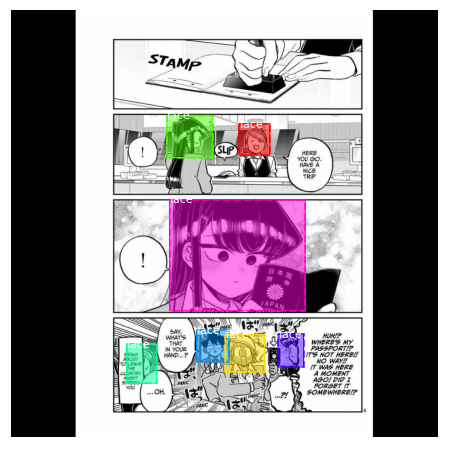

In [15]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

In [16]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


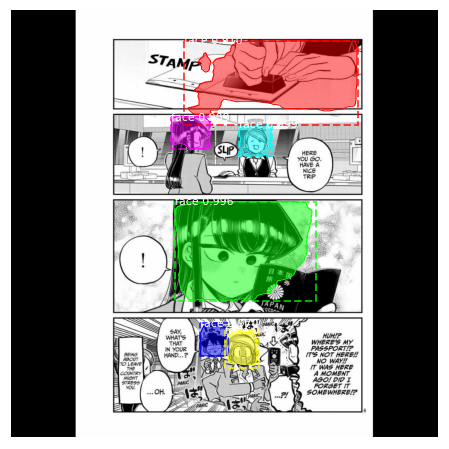

In [19]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            valid_dataset.class_names, r['scores'], ax=get_ax())

All the Code condesned

In [ ]:
import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.model as modellib
import os
import random
import xml.etree.ElementTree as ET
import xml
import numpy as np
import matplotlib.pyplot as plt
from mrcnn import visualize
from mrcnn.model import log
from os import listdir
from os.path import isfile, join

#replace with your own images and annotation path here down below
images_path = r'C:\Users\brunolopez\Downloads\komi_analysis_pascal\JPEGImages'
annot_path = r'C:\Users\brunolopez\Downloads\komi_analysis_pascal\Annotations'

class komiDataSet(mrcnn.utils.Dataset):

    def load_dataset(self, is_train = True):
        self.add_class("dataset", 1, 'face') #only one class which is a face detector

        images_dir = images_path
        annotations_dir = annot_path

        files = [file for file in os.listdir(images_dir)]
        random.shuffle(files) #randomly shuffle the files

        #Get the length of the files and navigate 80 percent for training
        split = 0.7    
        split_index = int(np.floor(len(files) * split))
        
        if is_train:
            files = files[:split_index]
        else:
            files = files[split_index:]

        for filename in files:
            image_id = filename.split('.jpg')[0] #split at the jpg
            #contruct the image path 
            img_path =  images_dir + '/' + filename
            ann_path = annotations_dir + '/' + image_id + '.xml'

            self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)

    def extract_boxes(self, filename):
        #get all of the x and y max and mins of the annotations
	    tree = xml.etree.ElementTree.parse(filename)
	    root = tree.getroot()
	    boxes = list()
	    for box in root.findall('.//bndbox'):
		    xmin = int(float(box.find('xmin').text))
		    ymin = int(float(box.find('ymin').text))
		    xmax = int(float(box.find('xmax').text))
		    ymax = int(float(box.find('ymax').text))
		    coors = [xmin, ymin, xmax, ymax]
		    boxes.append(coors)

	    width = int(root.find('.//size/width').text)
	    height = int(root.find('.//size/height').text)
	    return boxes, width, height
    
    def load_mask(self, image_id):
	    info = self.image_info[image_id]
	    path = info['annotation']
	    boxes, w, h = self.extract_boxes(path)
	    masks = np.zeros([h, w, len(boxes)], dtype='uint8')
	    class_ids = list()
	    for i in range(len(boxes)):
		    box = boxes[i]
		    row_s, row_e = box[1], box[3]
		    col_s, col_e = box[0], box[2]
		    masks[row_s:row_e, col_s:col_e, i] = 1
		    class_ids.append(self.class_names.index('face'))
	    return masks, np.asarray(class_ids, dtype='int32')


#config file for the mask-rcnn. Two classes are face and background
class KomiConfig(mrcnn.config.Config):
    NAME = "komi_cfg"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 131

class InferenceConfig(KomiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

train_set = komiDataSet()
train_set.load_dataset(is_train=True)
train_set.prepare()


valid_dataset = komiDataSet()
valid_dataset.load_dataset(is_train=False)
valid_dataset.prepare()


model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir= r'C:\Users\brunolopez\mldata\manga_scrape\komi_weights', 
                             config= KomiConfig())

coco_model = r'C:\Users\brunolopez\mldata\manga_scrape\mask_rcnn_coco.h5'

model.load_weights(filepath=coco_model, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

model.train(train_dataset=train_set, 
            val_dataset=valid_dataset, 
            learning_rate=KomiConfig().LEARNING_RATE, 
            epochs=10, 
            layers='heads')

model_path = os.path.join(r'C:\Users\brunolopez\mldata\manga_scrape\komi_weights', "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)


class InferenceConfig(KomiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=r'C:\Users\brunolopez\mldata\manga_scrape\komi_weights')

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax